# Final Project: What Video Game Genre will be popular next?

## Step 1. Introduce the Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("steam.csv")

df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


## Step 2: Data Visualization

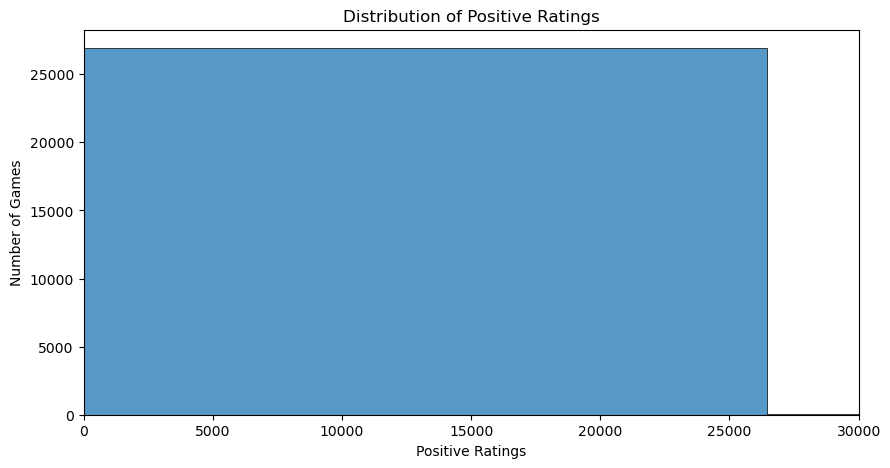

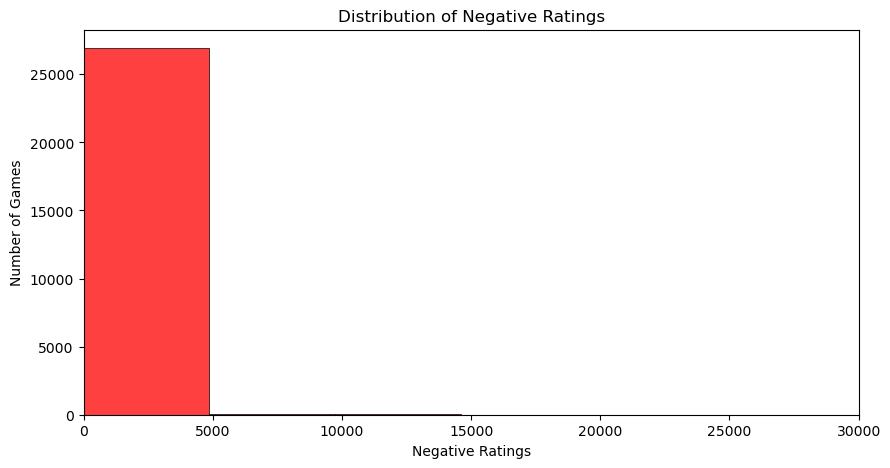

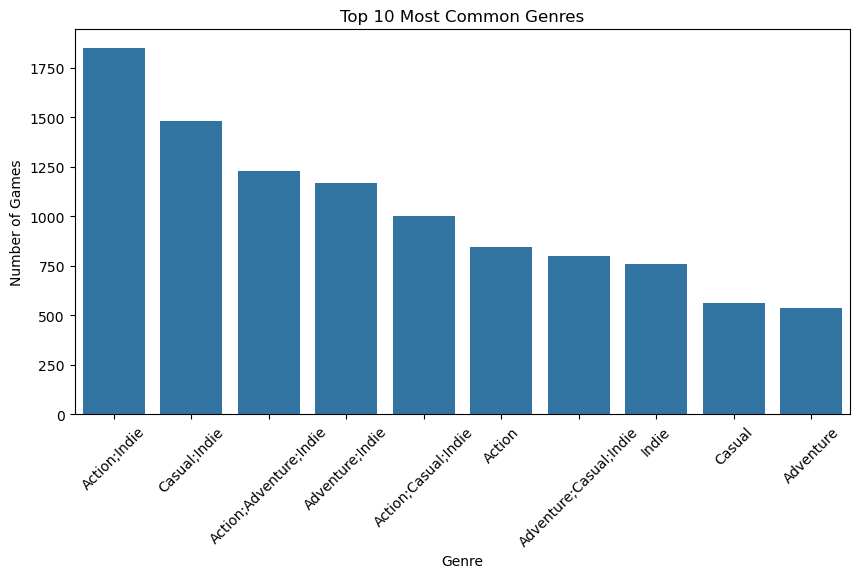

In [5]:
# 1. Positive Game Ratings
plt.figure(figsize=(10, 5))
sns.histplot(df['positive_ratings'], bins=100)
plt.title('Distribution of Positive Ratings')
plt.xlabel('Positive Ratings')
plt.ylabel('Number of Games')
plt.xlim(0, 30000)
plt.show()

# 2. Negative Ratings
plt.figure(figsize=(10, 5))
sns.histplot(df['negative_ratings'], bins=100, color='red')
plt.title('Distribution of Negative Ratings')
plt.xlabel('Negative Ratings')
plt.ylabel('Number of Games')
plt.xlim(0, 30000)
plt.show()

# 3. Top 10 Most Common Genres
plt.figure(figsize=(10, 5))
genre_counts = df['genres'].value_counts().head(10)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Top 10 Most Common Genres')
plt.ylabel('Number of Games')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

## Step 3: Data Preprocessing

In [7]:
# Create the score attribute (no division by zero)
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
df['score_percent'] = df.apply(
    lambda row: (row['positive_ratings'] / row['total_ratings'] * 100) if row['total_ratings'] > 0 else np.nan,
    axis=1
)

# Drop rows with no ratings at all
df = df.dropna(subset=['score_percent'])

# Preview
df[['positive_ratings', 'negative_ratings', 'total_ratings', 'score_percent']].head()


,positive_ratings,negative_ratings,total_ratings,score_percent
0,124534,3339,127873,97.388815
1,3318,633,3951,83.978740
2,3416,398,3814,89.564761
3,1273,267,1540,82.662338
4,5250,288,5538,94.799567


In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

def preprocess_steam_data(df):
    # Drop rows with missing critical values
    df = df.dropna(subset=['positive_ratings', 'negative_ratings', 'genres'])

    # Calculate score_percent (in this function)
    df['score_percent'] = df['positive_ratings'] / (df['positive_ratings'] + df['negative_ratings']) * 100

    # Define binary label, above 70 is positive on Steam
    df['label'] = (df['score_percent'] >= 70).astype(int)

    # Split genres by ";"
    df['genre_list'] = df['genres'].astype(str).apply(lambda x: x.split(';'))

    # One-hot encode genres
    mlb = MultiLabelBinarizer()
    genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre_list']),
                                  columns=mlb.classes_,
                                  index=df.index)

    # Final feature set includes ratings, score percentage, and genres
    X = pd.concat([df[['positive_ratings', 'negative_ratings', 'score_percent']], genre_encoded], axis=1)

    # Normalize numeric columns
    scaler = StandardScaler()
    X[['positive_ratings', 'negative_ratings', 'score_percent']] = scaler.fit_transform(
        X[['positive_ratings', 'negative_ratings', 'score_percent']]
    )

    # Labels for classification
    y = df['label']

    return X, y, df

# Checking results:
df = pd.read_csv("steam.csv")
X, y, df_clean = preprocess_steam_data(df)

print(f"Processed {len(df_clean)} samples with {X.shape[1]} features.")
print("Sample features:", X.columns[:100].tolist())

Processed 27075 samples with 32 features.
Sample features: ['positive_ratings', 'negative_ratings', 'score_percent', 'Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Free to Play', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent', 'Web Publishing']


## Step 4: Model Training and results

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2130
           1       0.98      0.99      0.99      3285

    accuracy                           0.98      5415
   macro avg       0.98      0.98      0.98      5415
weighted avg       0.98      0.98      0.98      5415

KNN Accuracy: 0.9820867959372115
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2130
           1       1.00      1.00      1.00      3285

    accuracy                           1.00      5415
   macro avg       1.00      1.00      1.00      5415
weighted avg       1.00      1.00      1.00      5415

Logistic Regression Accuracy: 0.9977839335180055


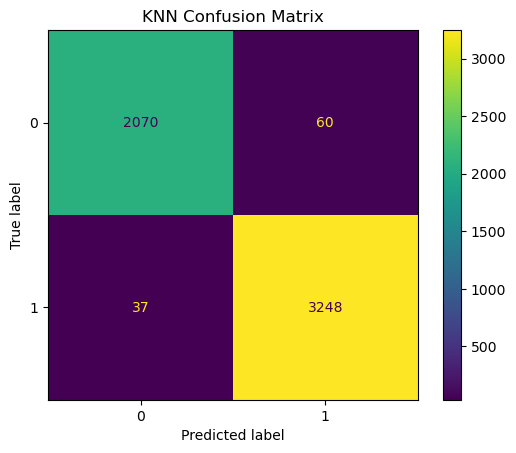

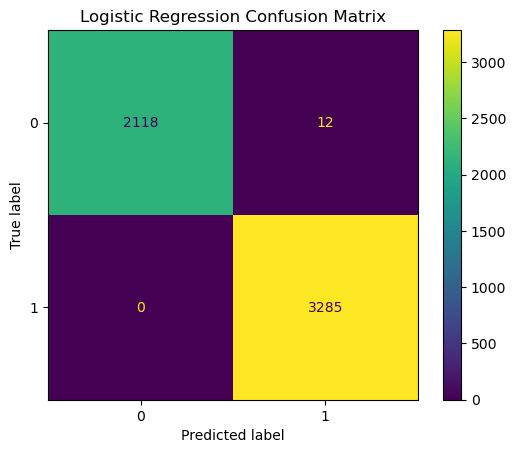

In [10]:
## TRAINING
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize KKN
knn = KNeighborsClassifier(n_neighbors=9)

# Train
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluation
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

## LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# Train
logreg.fit(X_train, y_train)

# Predict
y_pred_log = logreg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp_knn.plot()
plt.title("KNN Confusion Matrix")
plt.show()

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=logreg.classes_)
disp_log.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()
